## Comparison of convolution-based and fft-based filtering

In [2]:
import numpy as np
from matplotlib import pyplot as plt 
from scipy.stats import norm
from scipy.fft import fft, ifft
import bottleneck as bn
%matplotlib inline
plt.rcParams.update({'font.size': 8})

In [3]:
def cdf_diff(sig:np.ndarray, loc1:float, scale1:float, loc2:float, scale2:float):
    'Difference of 2 Gaussian CDFs'
    Nsig=len(sig)
    Nrfft=Nsig//2
    xarr=np.linspace(0,Nrfft/(2*Nrfft),Nrfft)
    WIN=norm.cdf(xarr,loc=loc1,scale=scale1)-norm.cdf(xarr,loc=loc2,scale=scale2)
    WIN=np.concatenate((WIN, np.array([WIN[-1],WIN[-1]]), np.flip(WIN[:-1])))
    sigfiltfft=np.real(ifft(WIN*fft(sig)))
    FSINC=WIN*fft(sinc(Nsig))
    filt=np.real(ifft(FSINC))
    filt=filt/np.sum(np.abs(filt))
    sigfiltconv=np.convolve(sig,filt,mode='same')
    return (sig, sigfiltconv, sigfiltfft, WIN)

In [4]:
def gauss(sig:np.ndarray, loc:float, scale:float):
    'Gaussian window filter'
    assert np.mod(len(sig),1) == 0, 'Length of signal must be odd'
    Nsig=len(sig)
    Nrfft=Nsig//2
    xarr=np.linspace(0,Nrfft/(2*Nrfft),Nrfft)
    WIN=norm.pdf(xarr,loc=loc,scale=scale)
    WIN=np.concatenate((WIN, np.array([WIN[-1],WIN[-1]]), np.flip(WIN[:-1])))
    sigfiltfft=np.real(ifft(WIN*fft(sig)))
    FSINC=WIN*fft(sinc(Nsig))
    filt=np.real(ifft(FSINC))
    filt=filt/np.sum(np.abs(filt))
    sigfiltconv=np.convolve(sig,filt,mode='same')
    return (sig, sigfiltconv, sigfiltfft, WIN)


In [5]:
def sinc(Nsamp:int=1001):
  'Sinc filter'
  Nsamp=2*(Nsamp//2)+1
  xarr=np.linspace(-Nsamp//2.25,Nsamp//2.25,Nsamp)
  fsinc=np.sinc(xarr)
  return fsinc

In [7]:
def genSweep(f0:float, f1:float, Nsamp:int):
  x=np.linspace(0,1,Nsamp)
  return np.sin(2.*np.pi*Nsamp*(f0*x+((f1-f0)/2.)*x**2))

In [8]:
def genSpike(k:int, Nsamp:int):
  x=np.zeros(Nsamp)
  x[k]=1
  return x

In [129]:
def plotResults(sig:np.ndarray, sigfiltconv:np.ndarray, sigfiltfft:np.ndarray, WIN:np.ndarray):   
    fig, axs=plt.subplots(3, 3)
    fig.set_size_inches(30, 15)
    Nfreqxlabel=8; freqxlabelint=np.linspace(0,(Nfreqxlabel-1)/Nfreqxlabel,Nfreqxlabel)
    #freqxlabels=['$0$', r'$\frac{1}{8}$', r'$\frac{1}{4}$', r'$\frac{3}{8}$', r'$-\frac{1}{2}$', r'$-\frac{3}{8}$', r'$-\frac{1}{4}$', r'$-\frac{1}{8}$']
    freqxlabels=[str(np.round(x,2)) for x in np.fft.fftfreq(Nfreqxlabel,1)]
    #--- signal function 
    idxSigmin=0; idxSigmax=len(sig)-1
    xsig=np.arange(len(sig))
    axs[0,0].plot(xsig[idxSigmin:idxSigmax],sig[idxSigmin:idxSigmax])
    axs[0,0].set_xlabel('Sample')
    axs[0,0].set_xlim(xsig[idxSigmin],xsig[idxSigmax])
    axs[0,0].set_title(label='Input signal',fontdict=None, loc='center', pad=None)
    #--- FFT amplitude of the input signal
    SIG=np.abs(fft(sig))
    freqs=np.arange(len(SIG))
    axs[0,1].fill_between(freqs,SIG,0.,color='maroon')
    axs[0,1].set(xlabel='Freq (normalized)', ylabel='FFT Amplitude')
    axs[0,1].set_xlim(freqs.min(),freqs.max())
    axs[0,1].set_xticks(len(SIG)*freqxlabelint)
    axs[0,1].set_xticklabels(freqxlabels)
    axs[0,1].set_title(label='FFT amplitude of input signal',fontdict=None, loc='center', pad=None)
    #--- FFT amplitude of the window function
    freqs=np.arange(len(WIN))
    axs[0,2].fill_between(freqs,WIN,0.,color='maroon')
    axs[0,2].set(xlabel='Freq (normalized)', ylabel='FFT Amplitude')
    axs[0,2].set_ylim(WIN.min(),WIN.max())
    axs[0,2].set_xlim(freqs.min(),freqs.max())
    axs[0,2].set_xticks(len(WIN)*freqxlabelint)
    axs[0,2].set_xticklabels(freqxlabels)
    axs[0,2].set_title(label='FFT window function',fontdict=None, loc='center', pad=None)
    #--- convolution-filtered signal
    idxmin=0; idxmax=len(sigfiltconv)-1
    xfilt=np.arange(len(sigfiltconv))
    axs[1,0].plot(xfilt[idxmin:idxmax],sigfiltconv[idxmin:idxmax])
    axs[1,0].set_xlabel('Sample')
    axs[1,0].set_xlim(xfilt[idxmin],xfilt[idxmax])
    axs[1,0].set_title(label='Convolution-filtered',fontdict=None, loc='center', pad=None)
    #--- FFT amplitude of the convolution-filtered signal
    SIG_FILT=np.abs(fft(sigfiltconv))
    freqs=np.arange(len(SIG_FILT))
    axs[1,1].fill_between(freqs,SIG_FILT,0.,color='maroon')
    axs[1,1].set(xlabel='Freq (normalized)', ylabel='FFT Amplitude')
    axs[1,1].set_xlim(freqs.min(),freqs.max())
    axs[1,1].set_xticks(len(SIG_FILT)*freqxlabelint)
    axs[1,1].set_xticklabels(freqxlabels)
    axs[1,1].set_title(label='FFT amplitude of convolution-filtered signal',fontdict=None, loc='center', pad=None)
    #--- FFT phase of the convolution-filtered signal
    SIG_FILT=np.unwrap(np.angle((fft(sigfiltconv))))
    freqs=np.arange(len(SIG_FILT))
    axs[1,2].plot(freqs,SIG_FILT,color='maroon')
    axs[1,2].set(xlabel='Freq (normalized)', ylabel='FFT Amplitude')
    axs[1,2].set_xlim(freqs.min(),freqs.max())
    axs[1,2].set_xticks(len(SIG_FILT)*freqxlabelint)
    axs[1,2].set_xticklabels(freqxlabels)
    axs[1,2].set_title(label='FFT phase of convolution-filtered signal',fontdict=None, loc='center', pad=None)
    #--- fft-filtered signal
    idxmin=0; idxmax=len(sigfiltfft)-1
    xfilt=np.arange(len(sigfiltfft))
    axs[2,0].plot(xfilt[idxmin:idxmax],sigfiltfft[idxmin:idxmax])
    axs[2,0].set_xlabel('Sample')
    axs[2,0].set_xlim(xfilt[idxmin],xfilt[idxmax])
    axs[2,0].set_title(label='FFT-filtered',fontdict=None, loc='center', pad=None)
    #--- FFT amplitude of the fft-filtered signal
    SIG_FILT=np.abs(fft(sigfiltfft))
    freqs=np.arange(len(SIG_FILT))
    axs[2,1].fill_between(freqs,SIG_FILT,0.,color='maroon')
    axs[2,1].set(xlabel='Freq (normalized)', ylabel='FFT Amplitude')
    axs[2,1].set_xlim(freqs.min(),freqs.max())
    axs[2,1].set_xticks(len(SIG_FILT)*freqxlabelint)
    axs[2,1].set_xticklabels(freqxlabels)
    axs[2,1].set_title(label='FFT amplitude of fft-filtered signal',fontdict=None, loc='center', pad=None)
    #--- FFT phase of the fft-filtered signal
    SIG_FILT=np.unwrap(np.angle((fft(sigfiltfft))))
    freqs=np.arange(len(SIG_FILT))
    axs[2,2].plot(freqs,SIG_FILT,color='maroon')
    axs[2,2].set(xlabel='Freq (normalized)', ylabel='FFT Amplitude')
    axs[2,2].set_xlim(freqs.min(),freqs.max())
    axs[2,2].set_xticks(len(SIG_FILT)*freqxlabelint)
    axs[2,2].set_xticklabels(freqxlabels)
    axs[2,2].set_title(label='FFT phase of fft-filtered signal',fontdict=None, loc='center', pad=None)
    #--- final adjsutments
    #fig.tight_layout()
    plt.show()

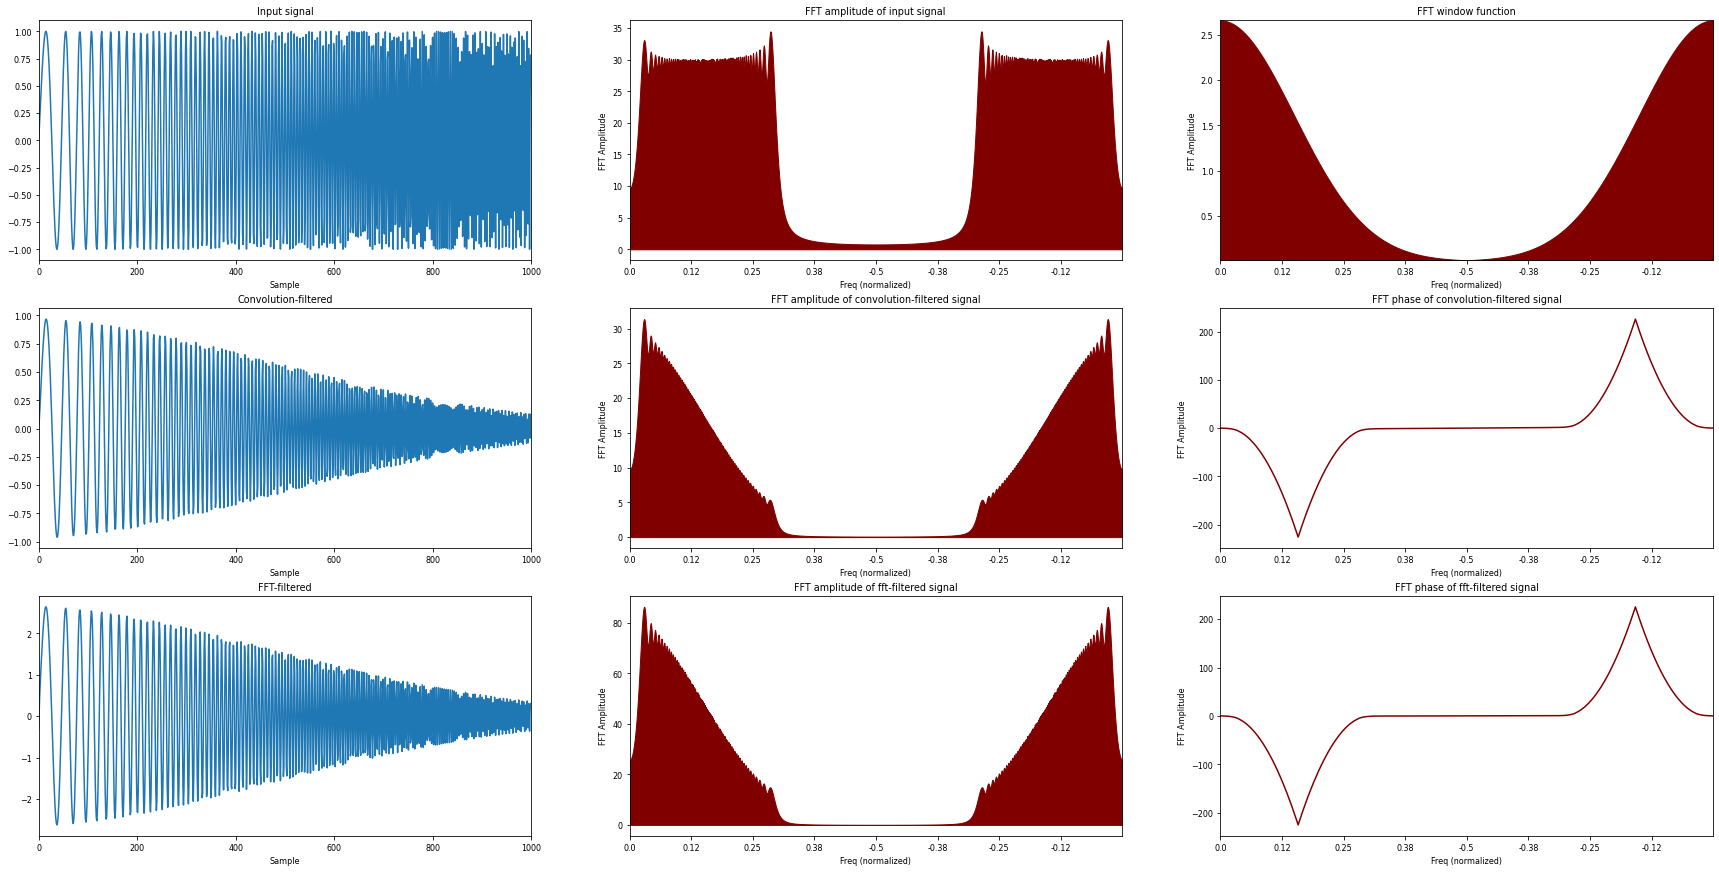

In [132]:
def main():
    mu_1=0.0;         mu_2=0.3
    sigma_1=0.15;     sigma_2=0.05
    #--- generate sweep signal
    f0=0.015; f1=0.3; Nsamp=1001; signal=genSweep(f0,f1,Nsamp)
    #--- generate spike signal
    # k= 100; Nsamp=1001; signal=genSpike(k,Nsamp)
    #--- filter the signal
    # sig, sigfiltconv, sigfiltfft, WIN = cdf_diff(sig=signal, loc1=mu_1, scale1=sigma_1, loc2=mu_2, scale2=sigma_2)
    sig, sigfiltconv, sigfiltfft, WIN = gauss(sig=signal, loc=mu_1, scale=sigma_1)
    #--- plot results
    plotResults(sig, sigfiltconv, sigfiltfft, WIN)
    
if __name__=="__main__":
    main()